In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms.v2 as v2_transforms
import os
from torch.utils.data import Dataset
from torchvision.io import ImageReadMode, read_image
from tqdm import tqdm
from torch.utils.data import ConcatDataset, DataLoader

In [4]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 3
NUM_WORKERS = 2
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
PIN_MEMORY = True
LOAD_MODEL = True
DATASET_DIR = "dataset"
ORIGINAL_DIR = "Original"
MASK_DIR = "Segmented"

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                out_channels,
                out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        out_channels=1,
        features=[64, 128, 256, 512],
    ):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # down part of the UNet
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # up part of the UNet
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if skip_connection.shape != x.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.final_conv(x)


model = UNet(in_channels=3, out_channels=5).to(DEVICE)

In [7]:
def load_checkpoint(checkpoint, model):
    print("=> Loading Checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

In [8]:
def extract_mask_label(multi_channel_mask):
    output_mask = multi_channel_mask[0]
    output_mask = output_mask.unsqueeze(0)

    means = []
    for dim in range(1, multi_channel_mask.size(0)):
        mean = multi_channel_mask[dim].mean()
        means.append(mean)

    label_id = torch.argmax(torch.tensor(means))
    return output_mask, label_id

def extract_mask_label_from_batch(multi_channel_mask_batch):
    masks = []
    labels = []
    for mask_idx in range(multi_channel_mask_batch.size(0)):
        mask, label = extract_mask_label(multi_channel_mask_batch[mask_idx])
        masks.append(mask.detach().cpu())
        labels.append(label.detach().cpu())

    return masks, labels

In [33]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device).float()
            y = y.to(device).float()
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            print(f"type(model(x)) = {type(model(x))}")
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(
        f"Got {num_correct}/{num_pixels} with accuracy {num_correct/num_pixels*100:.2f}\nDice Score: {dice_score/len(loader)}"
    )
    model.train()

In [27]:
def save_predictions_as_images(loader, model, folder="predictions", device="cuda"):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device).float()
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

        pred_images, labels = extract_mask_label_from_batch(preds)
        original_imgs, orig_labels = extract_mask_label_from_batch(y)
        for cur_idx in range(len(pred_images)):
            torchvision.utils.save_image(
                pred_images[cur_idx], os.path.join(folder, f"pred_{labels[cur_idx]}_{idx}.jpg")
            )
            torchvision.utils.save_image(
                original_imgs[cur_idx], os.path.join(folder, f"original_{labels[cur_idx]}_{idx}.jpg")
            )

In [11]:
class TrainTransform(torch.nn.Module):
    def forward(self, image, mask):
        # Resize
        resize = v2_transforms.Resize(size=(IMAGE_HEIGHT, IMAGE_WIDTH))
        image = resize(image)
        mask = resize(mask)

        # Rotate with a random angle
        range_angle = 35
        angle = (-range_angle - range_angle) * torch.rand(1) + range_angle
        image = TF.rotate(image, angle.item())
        mask = TF.rotate(mask, angle.item())

        # Random horizontal flipping
        if torch.rand(1).item() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if torch.rand(1).item() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        return image, mask

train_transform = v2_transforms.Compose([TrainTransform()])

class ValTransform(torch.nn.Module):
    def forward(self, image, mask):
        # Resize
        resize = v2_transforms.Resize(size=(IMAGE_HEIGHT, IMAGE_WIDTH))
        image = resize(image)
        mask = resize(mask)

        return image, mask

val_transform = v2_transforms.Compose([ValTransform()])

In [19]:
def get_label_id(label):
    match label:
        case "Benign":
            return 0
        case "Early":
            return 1
        case "Pre":
            return 2
        case "Pro":
            return 3
        case _:
            return -1


class MedicalImageDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        image = read_image(img_path, mode=ImageReadMode.RGB)
        image = image.float() / 255.0
        mask = read_image(mask_path, mode=ImageReadMode.RGB)
        mask = v2_transforms.Grayscale()(mask)
        mask[mask < 100] = 0.0
        mask[mask >= 100] = 1.0

        if self.transform is not None:
            image, mask = self.transform(image, mask)
            # image = self.transform(image.float())
            # mask = self.transform(mask.float())
            # augmentations = self.transform(image=image, mask=mask)
            # image = augmentations["image"]
            # mask = augmentations["mask"]

        label = get_label_id(os.path.basename(os.path.dirname(img_path)))

        # remove dimension
        mask = torch.squeeze(mask)

        # create a multi-channel mask with zeroes in the beginning
        multi_channel_mask = torch.zeros((5, mask.size(1), mask.unsqueeze(0).size(2)))

        # copy the mask to first channel
        multi_channel_mask[0][mask == 1.0] = 1.0

        # have a copy of the mask in label's channel
        multi_channel_mask[1][mask > 0] = 1.0 if label == 0 else 0.0
        multi_channel_mask[2][mask > 0] = 1.0 if label == 1 else 0.0
        multi_channel_mask[3][mask > 0] = 1.0 if label == 2 else 0.0
        multi_channel_mask[4][mask > 0] = 1.0 if label == 3 else 0.0

        # we need to use sigmoid on last activation

        return image, multi_channel_mask

In [20]:
def get_loaders(
    dataset_dir,
    original_dir,
    mask_dir,
    batch_size,
    train_transform,
    val_transform,
    num_workders=4,
    pin_memory=True,
    should_split=False,
):
    if should_split:
        # first we split data into train and test dir
        train_dir, test_dir = split_data(dataset_dir, original_dir, mask_dir)
    else:
        train_dir, test_dir = os.path.join(dataset_dir, "Train_Data"), os.path.join(
            dataset_dir, "Test_Data"
        )

    # now we create dataset from the train_dir and test_dir
    # there will be multiple datasets, so we need to keep that in mind
    image_dir = "Original"
    mask_dir = "Segmented"

    train_datasets = []
    val_datasets = []

    for d in os.listdir(os.path.join(train_dir, image_dir)):
        img_dir = os.path.join(train_dir, image_dir, d)
        msk_dir = os.path.join(train_dir, mask_dir, d)
        dataset = MedicalImageDataset(
            image_dir=img_dir, mask_dir=msk_dir, transform=train_transform
        )
        train_datasets.append(dataset)

    train_dataset = ConcatDataset(train_datasets)

    for d in os.listdir(os.path.join(test_dir, image_dir)):
        img_dir = os.path.join(test_dir, image_dir, d)
        msk_dir = os.path.join(test_dir, mask_dir, d)
        dataset = MedicalImageDataset(img_dir, msk_dir, transform=val_transform)
        val_datasets.append(dataset)

    val_dataset = ConcatDataset(val_datasets)

    # now create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=num_workders,
        pin_memory=pin_memory,
        shuffle=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        num_workers=num_workders,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader


train_loader, val_loader = get_loaders(
    DATASET_DIR,
    ORIGINAL_DIR,
    MASK_DIR,
    BATCH_SIZE,
    train_transform,
    val_transform,
    NUM_WORKERS,
    PIN_MEMORY,
    should_split=False,
)

In [24]:
load_checkpoint(torch.load("my_checkpoint.pth.zip"), model)

=> Loading Checkpoint


In [ ]:
check_accuracy(val_loader, model, device=DEVICE)

type(model(x)) = <class 'torch.Tensor'>
type(model(x)) = <class 'torch.Tensor'>
type(model(x)) = <class 'torch.Tensor'>
type(model(x)) = <class 'torch.Tensor'>


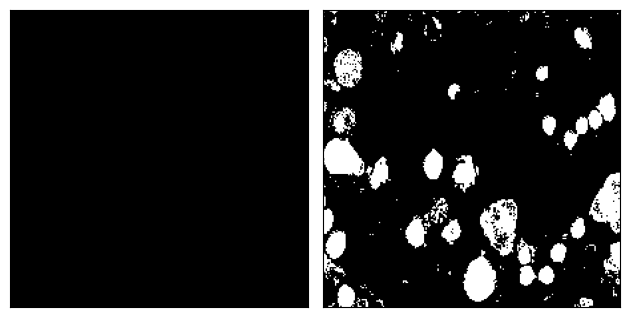

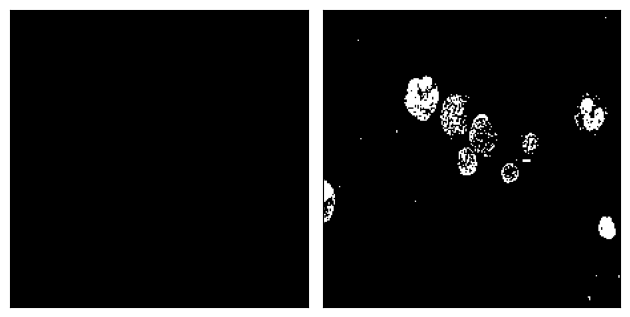

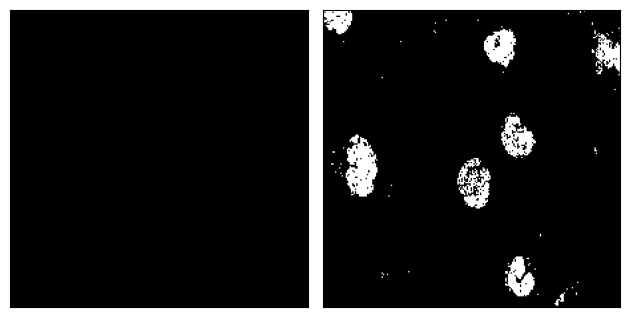

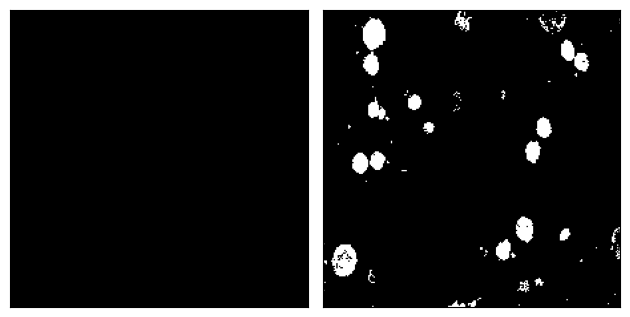

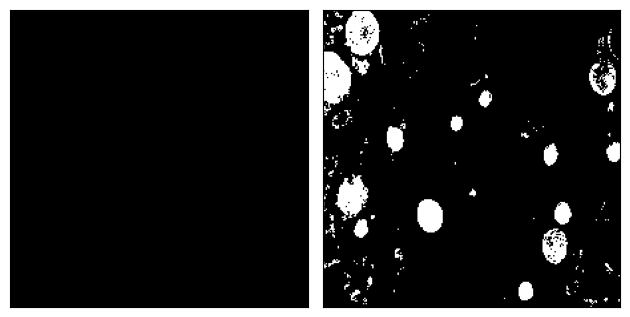

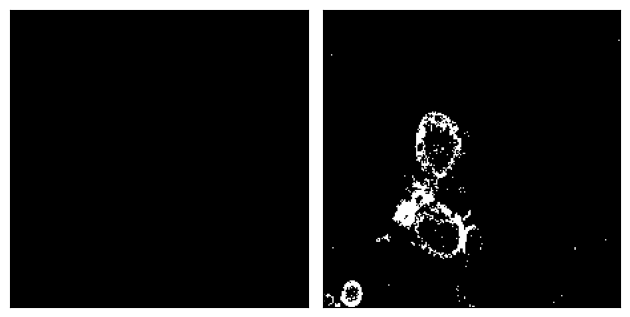

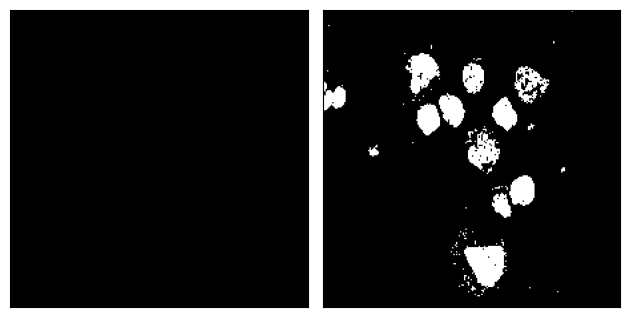

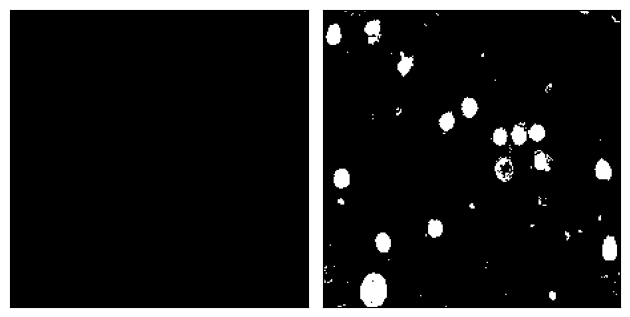

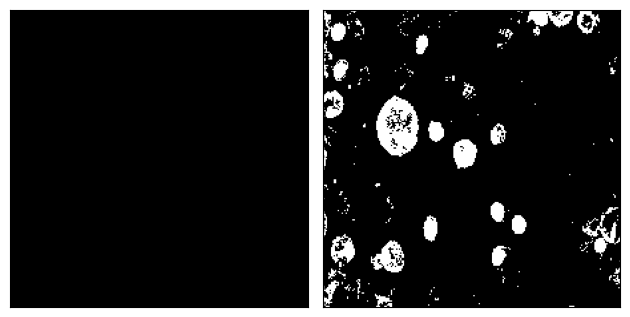

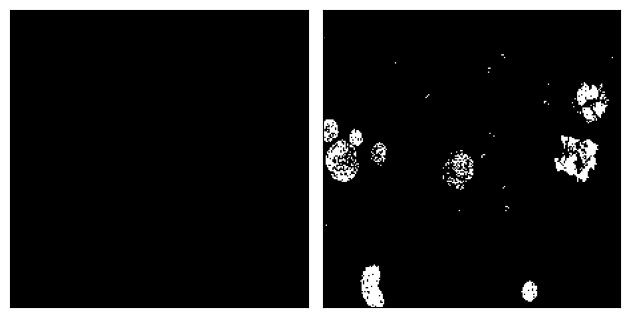

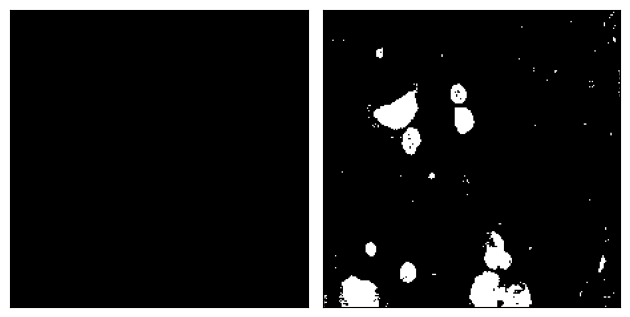

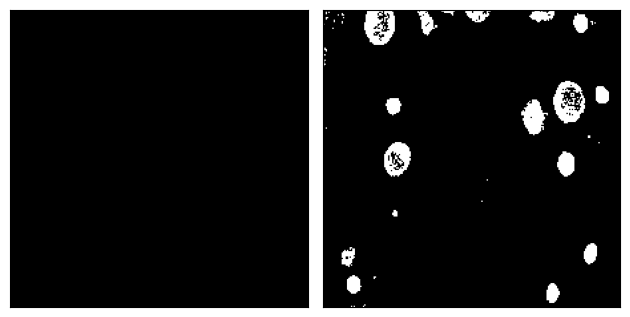

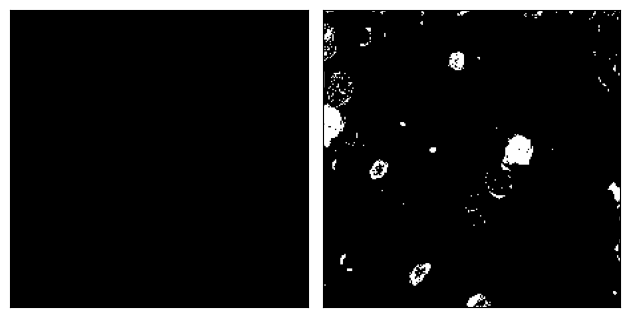

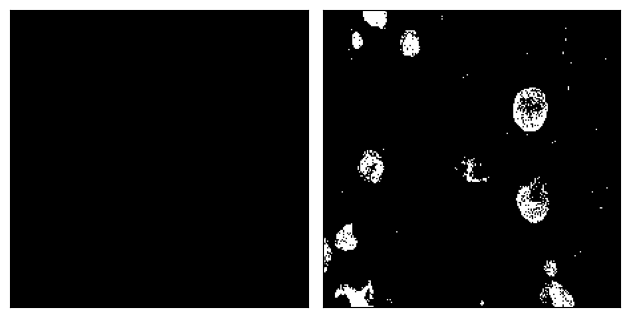

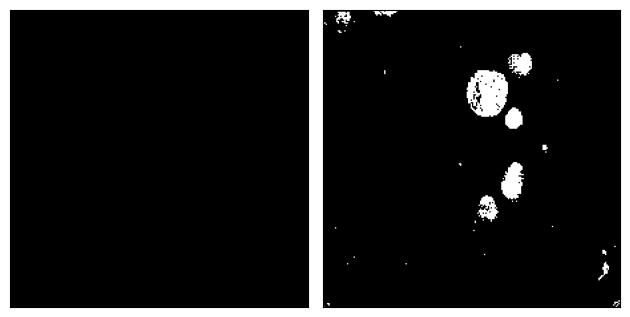

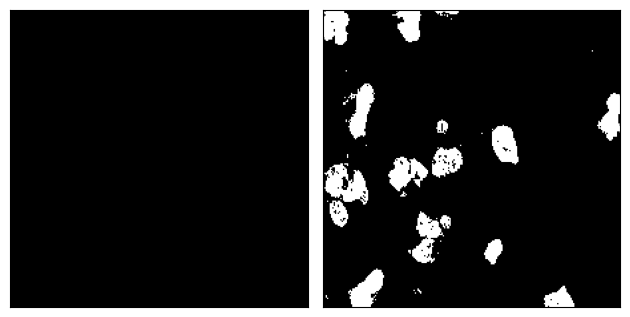

In [18]:
save_predictions_as_images(
    val_loader, model, folder="predictions", device=DEVICE
)
for idx, (x, y) in enumerate(val_loader):
    x = x.to(device=DEVICE).float()
    with torch.no_grad():
        preds = torch.sigmoid(model(x))
        preds = (preds > 0.5).float()

    pred_image, label = extract_mask_label_from_batch(preds)
    original_image, original_label = extract_mask_label_from_batch(y)

    for idx in range(len(pred_image)):
        plot([pred_image[idx], original_image[idx]], cmap='gray')

    break